# Analysis of differential expression across conditions

* Temperature: 10, 18, 25, 34
* Lighting: Dark, Light

__NOTES__:

1. So far I have computed DE among all samples disregarding effect of day cycle. I would need to compute DE between light and dark conditions, as well as DE for temperature for the two independent data sets (light, dark)
2. Regarding the two effects, I could find genes:

Condition | Temp (10 -> 34) 
--- | ---
Light | (+, -) 
Dark | (+, -) 

Hence, would be interesting to cluster genes based on the DE pattern, i.e., those which correlate with temperatur in the same manner under light or dark and those that differ...

3. Need also to establish which condition generates more variance: lighting or temperature?
4. GEMs of marine bacteria: https://www.sciencedirect.com/science/article/pii/S1874778717300508?via%3Dihub#bb0165
5. GEM reconstrution tools: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1769-1
6. Use Clust to cluster genes with significant DE among temperatures with similar patterns: https://github.com/BaselAbujamous/clust 

References:
* Rsubread: https://academic.oup.com/nar/article/47/8/e47/5345150
* DeSeq2: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
* Clust: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1536-8
* BRENDA: https://academic.oup.com/nar/article/49/D1/D498/5992283
* eQuilibrator: https://academic.oup.com/nar/article/40/D1/D770/2903458

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import Dokdonia_code as Dc
%matplotlib inline

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
# ax = counts.sum().plot.bar(figsize=(15, 10))
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,25566,41014,22449,53840,...,39444,41721,37020,39662,30983,27280,43105,44946,39311,57834
1,MED134_07384,1557,1555,1552,4160,4385,3383,5588,2940,7550,...,5419,5536,5318,5396,4751,4285,5108,4924,4503,7818
2,MED134_07379,3400,3319,3273,7218,7903,6315,9539,5040,13268,...,9089,9016,8529,10179,7617,7207,9484,8837,8743,13827
3,MED134_07374,1987,2124,1404,3509,3772,2846,4337,2602,4607,...,3586,3594,3488,4158,3096,2623,3818,3792,3538,5323
4,MED134_07369,2087,2010,2111,3774,3809,2921,4486,2901,4668,...,3705,4158,3760,5518,3563,2713,3679,3543,3356,5150


In [3]:
# Parsing GBK file
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
gbk.meta

{'organism': ['Dokdonia sp. MED134'],
 'mol_type': ['genomic DNA'],
 'strain': ['MED134'],
 'isolation_source': ['collected at a depth of 1 meter; isolated by plating on solid media'],
 'db_xref': ['taxon:313590'],
 'country': ['Mediterranean Sea']}

## Analysis of differential expression

We compare expression across temperature and between light and dark conditions.

## DE light vs dark across temperatures

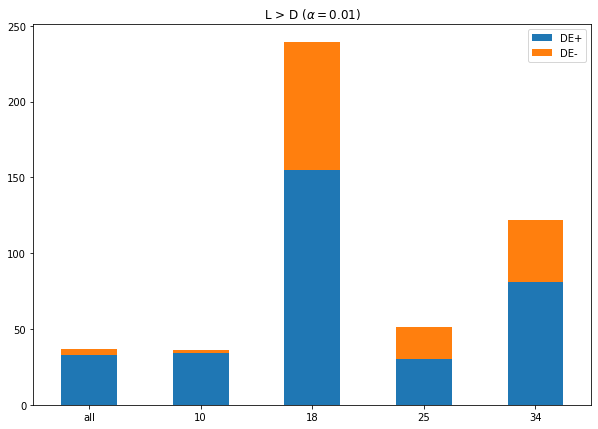

In [9]:
p_value_cutoff = 1e-2

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = Dc.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting')
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = Dc.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting')
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L > D ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [10]:
# L > D, T = 18 Proteins
res = L_D_res['18']
np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in res[res.log2FoldChange > 0].index])

array(['30S ribosomal protein S16', '30S ribosomal protein S20',
       '30S ribosomal protein S21', '50S ribosomal protein L31',
       '50S ribosomal protein L32', '50S ribosomal protein L34',
       '6-pyruvoyl tetrahydropterin synthase',
       'ABC transporter ATP-binding protein', 'ABC1 family protein',
       'ATP synthase, delta/epsilon subunit',
       'ATP-dependent protease La (LON)', 'Asp/Glu/hydantoin racemase',
       'DEAD/DEAH box helicase',
       'DNA photolyase/cryptochrome, animal cryptochrome and (6-4) photolyase subfamily',
       'DNA-directed RNA polymerase, omega subunit',
       'FAD dependent oxidoreductase', 'GSCFA family protein',
       'GTP cyclohydrolase I', 'LysE type translocator',
       'Orn/DAP/Arg decarboxylase', 'SCO2/SenC family protein',
       'TonB dependent/ligand-gated channel', 'YihY family protein',
       'ZIP zinc transporter family protein', 'acyl carrier protein',
       'adenylate kinase', 'amidohydrolase family protein',
       'argi

In [11]:
# D > L, T = 18 Proteins
res = L_D_res['18']
np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in res[res.log2FoldChange < 0].index])

array(['2-isopropylmalate synthase',
       '3-deoxy-7-phosphoheptulonate synthase/chorismate mutase type II',
       '3-isopropylmalate dehydrogenase', '30S ribosomal protein S13',
       '30S ribosomal protein S19', '30S ribosomal protein S4',
       '30S ribosomal protein S5', '50S ribosomal protein L27',
       '50S ribosomal protein L30', 'DNA-3-methyladenine glycosidase I',
       'FKBP-type peptidyl-prolyl cis-trans isomerase',
       'M42 glutamyl aminopeptidase',
       'MarC family integral membrane protein', 'OmpA family protein',
       'TldD protein', 'TonB dependent/ligand-gated channel',
       'acetyltransferase (GNAT) family protein',
       'acyl-CoA dehydrogenase', 'aldehyde dehydrogenase family protein',
       'aminotransferase class-V', 'diaminopimelate decarboxylase',
       'dihydroxy-acid dehydratase',
       'efflux transporter, RND family, MFP subunit', 'enolase',
       'gliding motility protein GldJ',
       'homocysteine S-methyltransferase', 'hypothetical

## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

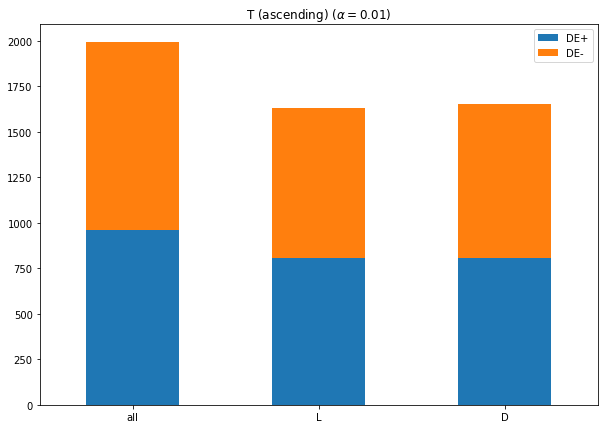

In [7]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = Dc.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = Dc.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')
    
# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

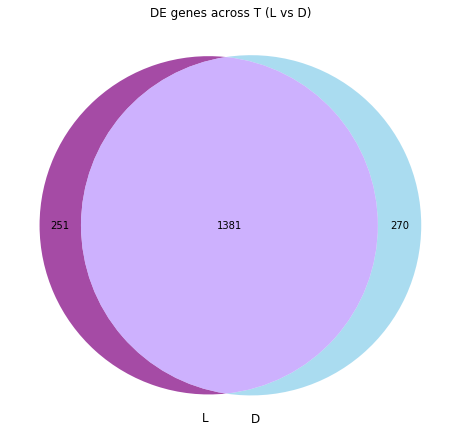

In [14]:
# Plot L-D Venn diagram
plt.figure(figsize=(8, 8))
set1 = set(T_res['L'].index)
set2 = set(T_res['D'].index)
venn2([set1, set2], ('L', 'D'),
      set_colors=('purple', 'skyblue'), alpha = 0.7)
plt.title('DE genes across T (L vs D)')
plt.show()

## Gene clustering based on expression pattern
We will employ _clust_ to cluster significant DE genes into groups of similar expression pattern across conditions. Let's first generate the tsv file required by _Clust_

In [22]:
tpm = pd.read_csv('Data/tpm_counts.csv', index_col=0)
tpm.index.name = 'ID'
tpm.columns = conditions

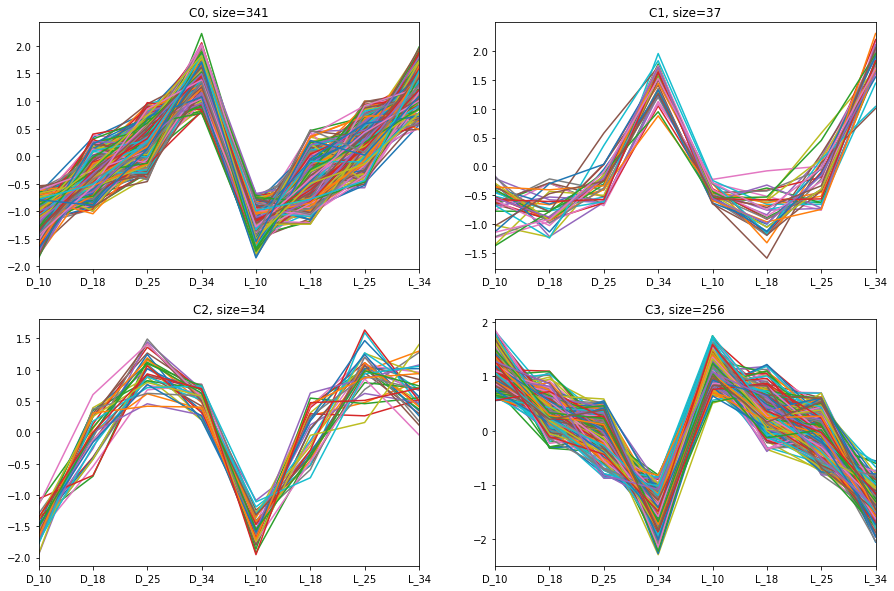

In [33]:
res_id = 'T_res_all'
workdir = os.path.join(os.getcwd(),'Data')
DE_TPM = tpm[tpm.index.isin(T_res['all'].index)]
clusters = Dc.getGeneClusters(DE_TPM, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=1)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Data/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')

fig, axes = plt.subplots(nrows=2, ncols=2)
coords = list(np.ndindex((2,2)))
for n, cluster_id in enumerate(clusters):
    i, j = coords[n]
    cluster = clusters[cluster_id]
    ax = pdata[pdata.index.isin(cluster)].transpose().plot(
        legend=False, figsize=(15, 10), title=f'{cluster_id}, size={len(cluster)}',
        ax=axes[i,j])

## Analyzing genes coding for enzymes


In [34]:
ec_genes = {}
for cluster_id, cluster in clusters.items():
    ec_genes[cluster_id] = np.unique(
        [gbk.getGeneInfo(gene_id)['product'][0] for gene_id in cluster if gbk.has_EC_number(gene_id)])

In [35]:
ec_genes

{'C0': array(['2-amino-3-ketobutyrate CoA ligase',
        '2-dehydro-3-deoxygluconokinase',
        '2-haloalkanoic acid dehalogenase, type II',
        '3-hydroxyanthranilate 3,4-dioxygenase',
        'Asp/Glu/hydantoin racemase',
        'D-alanyl-D-alanine carboxypeptidase', 'DNA adenine methylase',
        'DNA gyrase subunit B', 'DNA polymerase III subunit gamma/tau',
        'DNA polymerase III, beta subunit',
        'DNA topoisomerase IV subunit A', 'DNA topoisomerase IV subunit B',
        'DNA-directed DNA polymerase',
        'N-acetylmuramoyl-L-alanine amidase', 'NAD+ synthase',
        'UDP-N-acetylglucosamine1- carboxyvinyltransferase',
        'UDP-N-acetylmuramoylalanine-D-glutamate ligase',
        'UDP-N-acetylmuramoylalanyl-D-glutamate-2, 6-diaminopimelate ligase',
        'UDP-N-acetylmuramoylalanyl-D-glutamyl-2, 6-diaminopimelate-D-alanyl-D-alanyl ligase',
        'acetyl-CoA carboxylase carboxyl transferase subunit alpha',
        'allophanate hydrolase subunit 2

## Taking a look at selected genes with high log2 fold change (34º vs 10º)

Evaluating gene: MED134_08511


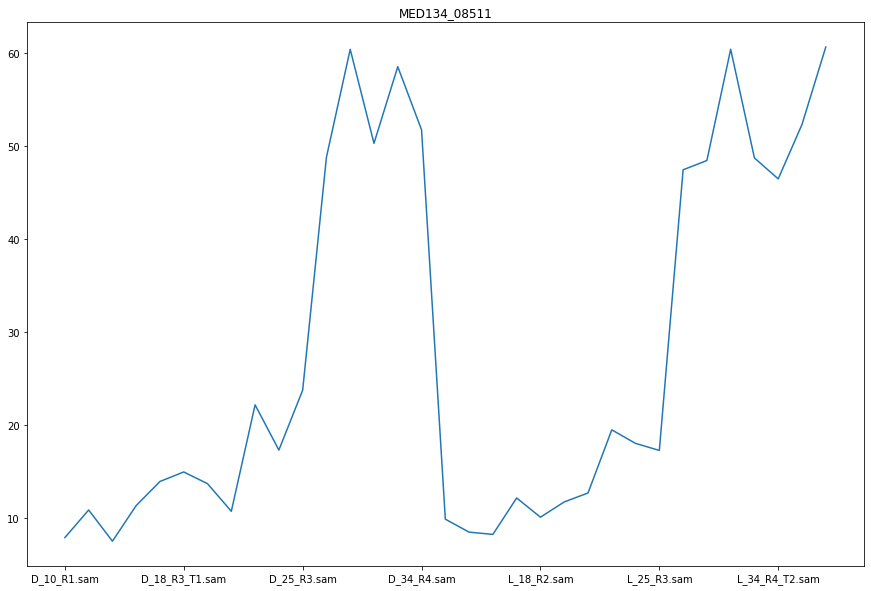

In [184]:
gene_id = pos_corr_genes[30]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

Evaluating gene: MED134_05724


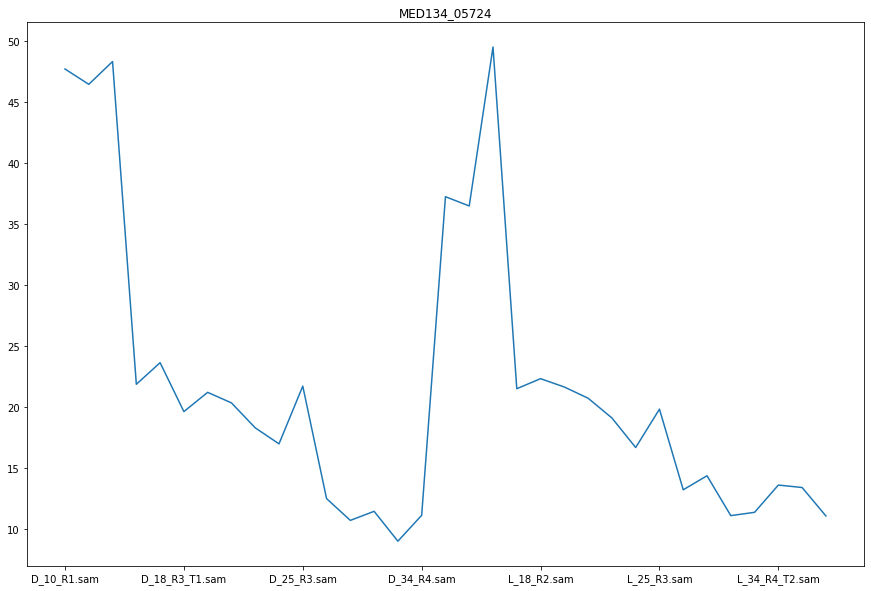

In [52]:
gene_id = neg_corr_genes[5]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

In [255]:
gene_id = 'MED134_07089' # THe EC corresponds to adenylate cyclase... however protein EAQ40501.1 has no annotation 
gbk.getGeneInfo(gene_id)

{'locus_tag': ['MED134_07089'],
 'EC_number': ['4.6.1.1'],
 'codon_start': ['1'],
 'transl_table': ['11'],
 'product': ['sensor of blue-light using FAD'],
 'protein_id': ['EAQ40501.1'],
 'translation': ['MYTICYLSKVSPHLTETQIQEIFDHTYAQNNKKGICGILLHTMGNFFQVLEGDEAYLTDLYENRIKKDPRHHSIFEVIHKEGSDPVFTSYSSRFLTIEDSDALNDIKTYVKKHAVVSSTSDKIARLLNTVEMLTY'],
 'location': FeatureLocation(ExactPosition(67655), ExactPosition(68063), strand=-1)}

In [260]:
# Trying out ec finder (Pyruvate kinase) [CO2] in solution higher with cold
gbk.getEnzymeGene('2.7.1.40')

['MED134_09046']

Evaluating gene: MED134_09046


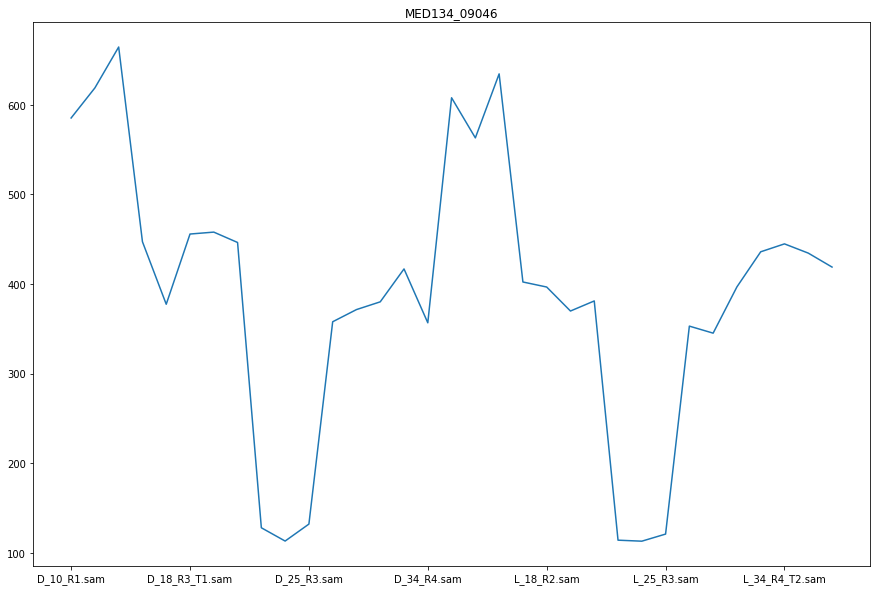

In [261]:
gene_id = gbk.getEnzymeGene('2.7.1.40')[0]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

In [265]:
res[gene_id] # Weird that this one is not among DE... perhaps because only comparing 34 vs 10 degress...

In [11]:
# This part to be used with pair-wise comparisons (no LRT)
neg_corr_genes = res[res.log2FoldChange < -1].index.tolist()
pos_corr_genes = res[res.log2FoldChange > 1].index.tolist()
print(f'There are: {len(pos_corr_genes)} positive genes and {len(neg_corr_genes)} negative')

There are: 0 positive genes and 0 negative


## Finding metabolic genes (EC number) among DE

In [191]:
met_pos_genes = [gene_id for gene_id in pos_corr_genes if gbk.has_EC_number(gene_id)]
met_neg_genes = [gene_id for gene_id in neg_corr_genes if gbk.has_EC_number(gene_id)]
print(f'There are: {len(met_pos_genes)} positive genes with EC and {len(met_neg_genes)} negative')

There are: 22 positive genes with EC and 42 negative


In [194]:
# Which enzymes are negatively correlated with temperature?
print([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in met_neg_genes])

['6-phosphofructokinase', 'glyceraldehyde-3-phosphate dehydrogenase A', 'phosphoribosylformylglycinamidine synthase', 'imidazole glycerol phosphate synthase subunit HisF', 'methylmalonyl-CoA mutase', 'glutamate-ammonia ligase', 'propionyl-CoA carboxylase beta chain', 'two-component system sensor histidine kinase', 'DNA-directed RNA polymerase beta chain', 'prephenate dehydratase', 'tRNA-guanine transglycosylase', 'NADH dehydrogenase', 'O-acetylhomoserineaminocarboxypropyltransferase', 'inorganic pyrophosphatase', 'ATP-dependent Clp protease proteolytic subunit', 'FKBP-type peptidyl-prolyl cis-transisomerase', 'glycogen synthase', 'ribose-phosphate pyrophosphokinase', '3-oxoacid CoA-transferase, B subunit', '3-oxoacid CoA-transferase, A subunit', 'pyruvate kinase', 'amidophosphoribosyltransferase', 'choline dehydrogenase', 'glutamate dehydrogenase', 'sulfate permease', 'saccharopine dehydrogenase (NADP+, L-glutamate forming)', 'crossover junction endodeoxyribonuclease RuvC', 'oxygen-ind

In [195]:
# Which enzymes are positively correlated with temperature?
print([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in met_pos_genes])

['sensor of blue-light using FAD', 'oligo-1,6-glucosidase', 'hydroxymethylglutaryl-CoA lyase', 'pyruvate carboxylase', 'glyceraldehyde-3-phosphate dehydrogenase A', 'isocitrate lyase', 'malate synthase', 'two-component system sensor histidine kinase', 'Asp/Glu/hydantoin racemase', 'D-amino acid dehydrogenase small subunit', 'proline racemase', 'catalase/peroxidase HPI', 'peptide-methionine (S)-S-oxide reductase', 'phosphoenolpyruvate carboxykinase (ATP)', '2-dehydro-3-deoxygluconokinase', 'alginate lyase precursor', 'alginate lyase', 'ribonuclease HII', 'pyrimidine operon attenuation protein / uracil phosphoribosyltransferase', 'two-component system sensor histidine kinase', 'sulfate adenylyltransferase subunit 2', 'sulfate adenylyltransferase subunit 1']


## Connecting expression to metabolism
* Identify genes coding for enzymes
* Get thermodynamic information for the reaction (equilibrator)
These would give an idea of which reactions may be happening as well as the direction of flow

In [2]:
from brendapyrser import BRENDA
brenda_path = 'C:/Users/tinta/OneDrive/Documents/Projects/BRENDA/data/brenda_download.txt'
brenda = BRENDA(brenda_path)
brenda

Number of Enzymes,7558
BRENDA copyright,"Copyrighted by Dietmar Schomburg, Techn. University Braunschweig, GERMANY. Distributed under the License as stated at http:/www.brenda-enzymes.org"
Parser version,0.1.0
Author,"Semidán Robaina Estévez, 2020"


In [3]:
brenda.reactions.get_by_id('2.7.1.40')

Enzyme identifier,2.7.1.40
Name,Pyruvate kinase
Systematic name,ATP:pyruvate 2-O-phosphotransferase
Reaction type,Phospho group transfer
Reaction,ATP + pyruvate <=> ADP + phosphoenolpyruvate


# Notes on possible errors in annotation
1. MED134_07089: The EC number corresponds to [adenylate cyclase](https://www.brenda-enzymes.org/enzyme.php?ecno=4.6.1.1) however protein [EAQ40501.1](https://string-db.org/network/313590.MED134_07089) isn't annotated, and the product description is "sensor of blue light using FAD". After searching for EC number ('4.6.1.1') I found another gene: MED134_03369, which seems to be the true adenylate cyclase!.

In [ ]:
res_id = 'T_res_L'
workdir = os.path.join(os.getcwd(),'Data')
DE_TPM = tpm[tpm.index.isin(T_res['L'].index)]
clusters = Dc.getGeneClusters(DE_TPM, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=1)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Data/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
pdata = pdata[pdata.filter(regex='L').columns] 
fig, axes = plt.subplots(nrows=2, ncols=2)
coords = list(np.ndindex((2,2)))
for n, cluster_id in enumerate(clusters):
    i, j = coords[n]
    cluster = clusters[cluster_id]
    ax = pdata[pdata.index.isin(cluster)].transpose().plot(
        legend=False, figsize=(15, 10), title=f'{cluster_id}, size={len(cluster)}',
        ax=axes[i,j])